In [1]:
# untar
!tar -xvzf dataset.tar.gz

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [2]:
import os
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from copy import deepcopy

from matplotlib import pyplot as plt

%matplotlib inline

print(tf.version.VERSION)

2.12.0


In [3]:
# load train
train_images = pickle.load(open("../train_images.pkl", "rb"))
train_labels = pickle.load(open("../train_labels.pkl", "rb"))

# load val
val_images = pickle.load(open("../val_images.pkl", "rb"))
val_labels = pickle.load(open("../val_labels.pkl", "rb"))


In [4]:
def measure_sparsity(weights):
    num_zeros = 0
    num_nonzeros = 0
    for weight in weights:
        z = tf.math.count_nonzero(tf.equal(weight, 0)).numpy()
        nz = tf.size(weight).numpy() - z
        num_zeros += z
        num_nonzeros += nz

    return num_zeros / (num_zeros + num_nonzeros)

In [6]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 11, 11, 32)        0         
                                                      

In [15]:
import math

def compute_value(inputs, tmpT):
  inp = tf.gather(inputs, tmpT, axis=-1)
  x = tf.math.square(tf.math.reduce_sum(inp, axis=-1))
  obj_val = tf.math.reduce_sum(x)
  return obj_val


def greedy_channel_selection(inputs, C, sparsity=0.2):
  indices_pruned = []
  num_pruned = int(math.ceil(C * sparsity))
  while len(indices_pruned) < num_pruned:
    min_value = 1e10
    min_i = -1
    for i in range(C):
      if i in indices_pruned:
        continue
      tmpT = indices_pruned + [i]
      val = compute_value(inputs, tmpT)
      if val < min_value:
        min_value = val
        min_i = i
    indices_pruned.append(min_i)

  indices_stayed = list(set([i for i in range(C)]) - set(indices_pruned))
  return indices_pruned, indices_stayed


def prune(model, train_images, conv_sparsity=0.3, dense_sparsity=None):
  pruned_weights = []
  inp = deepcopy(train_images)
  for layer in model.layers: 
    layer_out = layer(inp)
    if isinstance(layer, Conv2D):
      weights, biases = layer.get_weights()
      
      w = deepcopy(weights)
      b = deepcopy(biases)

      C = weights.shape[-1]
      indices_pruned, indices_stayed = greedy_channel_selection(layer_out, C, conv_sparsity)

      w[:, :, :, indices_pruned] = 0.0
      b[indices_pruned] = 0.0
      
      pruned_weights.append(w)
      pruned_weights.append(b)
    
    elif isinstance(layer, Dense):
      weights, biases = layer.get_weights()
      w = deepcopy(weights)
      b = deepcopy(biases)

      if dense_sparsity is not None:
        C = weights.shape[-1]
        indices_pruned, indices_stayed = greedy_channel_selection(layer_out, C, dense_sparsity)

        w[:, indices_pruned] = 0.0
        b[indices_pruned] = 0.0

      pruned_weights.append(w)
      pruned_weights.append(b)
    
    inp = layer_out

  return pruned_weights


In [7]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")

for i in range(10):
    pruned_weights = prune(model, train_images, conv_sparsity=0.3, dense_sparsity=0.2)
    model.set_weights(pruned_weights)

    checkpoint_path = f"thinet_pruning_itr_{i}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        monitor="val_accuracy"
    )

    model.fit(
        x=train_images, 
        y=train_labels,
        epochs=30, 
        batch_size=128, 
        validation_data=(val_images, val_labels),
        callbacks=[cp_callback]
    )

    val_loss, val_acc = model.evaluate(val_images, val_labels)
    sparsity = measure_sparsity(model.trainable_weights)

    print(f"Sparsity: {sparsity} | val loss: {val_loss} | val acc: {val_acc}")


Epoch 1/30
176/176 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.6310
Epoch 1: saving model to thinet_pruning_itr_0.h5
176/176 [==============================] - 6s 12ms/step - loss: 0.9625 - accuracy: 0.6310 - val_loss: 0.8951 - val_accuracy: 0.6539
Epoch 2/30
174/176 [============================>.] - ETA: 0s - loss: 0.7658 - accuracy: 0.7149
Epoch 2: saving model to thinet_pruning_itr_0.h5
176/176 [==============================] - 2s 9ms/step - loss: 0.7658 - accuracy: 0.7147 - val_loss: 0.8530 - val_accuracy: 0.6685
Epoch 3/30
174/176 [============================>.] - ETA: 0s - loss: 0.6909 - accuracy: 0.7415
Epoch 3: saving model to thinet_pruning_itr_0.h5
176/176 [==============================] - 2s 9ms/step - loss: 0.6910 - accuracy: 0.7414 - val_loss: 0.8301 - val_accuracy: 0.6745
Epoch 4/30
175/176 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.7603
Epoch 4: saving model to thinet_pruning_itr_0.h5
176/176 [=================

79/79 [==============================] - 1s 12ms/step - loss: 0.8018 - accuracy: 0.7370


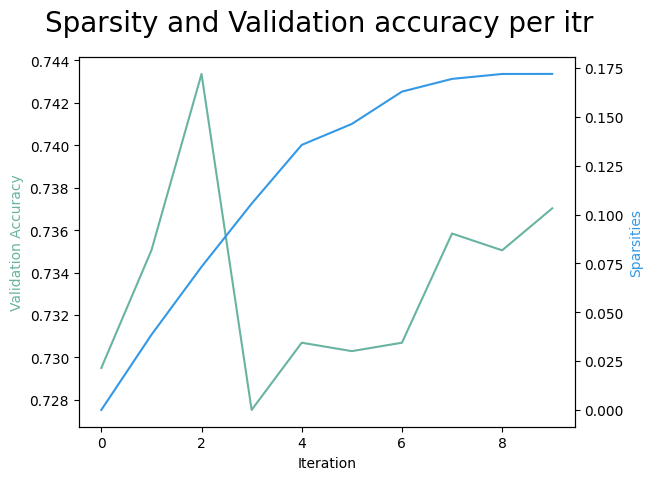

In [7]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")

saved_res_files = sorted([file for file in os.listdir() if file.endswith(".h5")])

sparsities = []
val_accs = []

for file in saved_res_files:
  model.load_weights(file)
  val_loss, val_acc = model.evaluate(val_images, val_labels)
  sparsity = measure_sparsity(model.trainable_weights)
  sparsities.append(sparsity)
  val_accs.append(val_acc)
    
itrs = list(range(len(saved_res_files)))

COLOR_VAL_ACC = "#69b3a2"
COLOR_SPARSITY = "#3399e6"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(itrs, val_accs, color=COLOR_VAL_ACC)
ax2.plot(itrs, sparsities, color=COLOR_SPARSITY)

fig.suptitle("Sparsity and Validation accuracy per itr", fontsize=20)

ax1.set_xlabel("Iteration")

ax1.set_ylabel("Validation Accuracy", color=COLOR_VAL_ACC)
ax2.set_ylabel("Sparsities", color=COLOR_SPARSITY)

plt.show()

In [12]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")
model_path = "thinet_pruning_itr_9.h5"
model.load_weights(model_path)

final_results = model.evaluate(val_images, val_labels)
final_model_sparsity = measure_sparsity(model.trainable_weights)

print(f"Post retraining val loss: {final_results[0]} | val acc: {final_results[1]} | sparsity: {final_model_sparsity}")

79/79 [==============================] - 0s 2ms/step - loss: 0.8018 - accuracy: 0.7370
Post retraining val loss: 0.8017615079879761 | val acc: 0.7370297312736511 | sparsity: 0.17201774905427764


In [18]:
model = keras.models.load_model("../unpruned_val_acc_0.7493.h5")
unpruned_weights = deepcopy(model.trainable_weights)

factors = np.linspace(0.1, 1, num=20)
val_loss, val_acc = model.evaluate(val_images, val_labels)

val_losses = [val_loss]
val_accuracies = [val_acc]
sparsities = [0]

for factor in factors:
    pruned_weights = prune(model, train_images, conv_sparsity=factor, dense_sparsity=None)
    model.set_weights(pruned_weights)
    
    val_loss, val_acc = model.evaluate(val_images, val_labels)
    sparsity = measure_sparsity(model.trainable_weights)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    sparsities.append(sparsity)
    
    print(f"Factor: {factor} | Sparsity: {sparsity} | val loss: {val_loss} | val acc: {val_acc}")
    model.set_weights(unpruned_weights)


79/79 [==============================] - 0s 2ms/step - loss: 1.3642 - accuracy: 0.6404
Factor: 0.1 | Sparsity: 0.012362273646432227 | val loss: 1.3642396926879883 | val acc: 0.6403960585594177
79/79 [==============================] - 0s 2ms/step - loss: 1.2413 - accuracy: 0.6455
Factor: 0.1473684210526316 | Sparsity: 0.017278512074720077 | val loss: 1.2413172721862793 | val acc: 0.6455445289611816
79/79 [==============================] - 0s 2ms/step - loss: 2.3065 - accuracy: 0.4931
Factor: 0.19473684210526315 | Sparsity: 0.022729380891264275 | val loss: 2.3064682483673096 | val acc: 0.4930693209171295
79/79 [==============================] - 0s 2ms/step - loss: 2.6342 - accuracy: 0.4349
Factor: 0.24210526315789474 | Sparsity: 0.027645619319552124 | val loss: 2.6341843605041504 | val acc: 0.4348514974117279
79/79 [==============================] - 0s 2ms/step - loss: 1.8589 - accuracy: 0.4772
Factor: 0.2894736842105263 | Sparsity: 0.03309648813609632 | val loss: 1.8588836193084717 | va

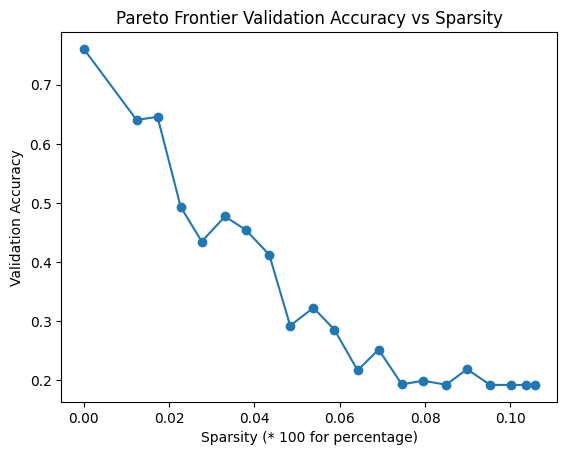

In [19]:
fig, axes = plt.subplots()
axes.plot(sparsities, val_accuracies, marker="o")
axes.set_title("Pareto Frontier Validation Accuracy vs Sparsity")
axes.set_xlabel("Sparsity (* 100 for percentage)")
axes.set_ylabel("Validation Accuracy")

plt.show()